<a href="https://colab.research.google.com/github/F0lty/SpeechEmotionRecognition/blob/main/Speech_Emotion_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import os
from matplotlib.pyplot import specgram
from keras.preprocessing import sequence
from keras.optimizers import RMSprop
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras import regularizers
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
from keras.callbacks import EarlyStopping
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D,BatchNormalization,GlobalMaxPooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from PIL import Image
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials


In [2]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [3]:
basepath = 'drive/MyDrive/Colab Notebooks'
folders = os.listdir("{}/RAVDEESTalk".format(basepath))

folders = np.array(folders)
print(folders)

['Actor_01' 'Actor_03' 'Actor_02' 'Actor_04' 'Actor_05' 'Actor_07'
 'Actor_06' 'Actor_08' 'Actor_09' 'Actor_10' 'Actor_11' 'Actor_12'
 'Actor_13' 'Actor_14' 'Actor_15' 'Actor_16' 'Actor_17' 'Actor_18'
 'Actor_19' 'Actor_20' 'Actor_21' 'Actor_22' 'Actor_23' 'Actor_24']


In [4]:
data = []
emotions = []

In [5]:
def getLabel(name):
    nm = name.split('.')[0].split('-')
    emotion = int(nm[2])
    typ = int(nm[1])
    if emotion == 1:
        lb = "neutral"
    elif emotion == 2:
        lb = "calm"
    elif emotion == 3:
        lb = "happy"
    elif emotion == 4:
        lb = "sad"
    elif emotion == 5:
        lb = "angry"
    elif emotion == 6:
        lb = "fearful"
    elif emotion == 7:
        lb = "disgust"
    elif emotion == 8:
        lb = "surprise"
    return lb

In [6]:
for i,foldersName in enumerate(folders):
    files = os.listdir("{}/RAVDEESTalk/{}".format(basepath,foldersName))
    print(foldersName)
    for a,fileName in enumerate(files):
      sample, sr = librosa.load(basepath+'/RAVDEESTalk/'+foldersName+'/'+fileName, res_type='kaiser_fast',duration=2.4,offset=0.5)
      sr = np.array(sr)
      stft = np.abs(librosa.stft(sample))
      result = np.array([])
      mfccs = np.mean(librosa.feature.mfcc(y=sample, sr=sr, n_mfcc=40).T, axis=0)
      result = np.hstack((result, mfccs))
      chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sr).T,axis=0)
      result = np.hstack((result, chroma))
      mel = np.mean(librosa.feature.melspectrogram(sample, sr=sr).T,axis=0)
      result = np.hstack((result, mel))
      contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sr).T,axis=0)
      result = np.hstack((result, contrast))
      data.append(result)
      emotions.append(getLabel(fileName))
for i,foldersName in enumerate(folders):
    files = os.listdir("{}/RAVDEESSing/{}".format(basepath,foldersName))
    print(foldersName)
    for a,fileName in enumerate(files):
      sample, sr = librosa.load(basepath+'/RAVDEESSing/'+foldersName+'/'+fileName,res_type='kaiser_fast',duration=2.4,offset=0.5)
      sr = np.array(sr)
      stft = np.abs(librosa.stft(sample))
      result = np.array([])
      mfccs = np.mean(librosa.feature.mfcc(y=sample, sr=sr, n_mfcc=40).T, axis=0)
      result = np.hstack((result, mfccs))
      chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sr).T,axis=0)
      result = np.hstack((result, chroma))
      mel = np.mean(librosa.feature.melspectrogram(sample, sr=sr).T,axis=0)
      result = np.hstack((result, mel))
      contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sr).T,axis=0)
      result = np.hstack((result, contrast))

      data.append(result)
      emotions.append(getLabel(fileName))

Actor_01
Actor_03
Actor_02
Actor_04
Actor_05
Actor_07
Actor_06
Actor_08
Actor_09
Actor_10
Actor_11
Actor_12
Actor_13
Actor_14
Actor_15
Actor_16
Actor_17
Actor_18
Actor_19
Actor_20
Actor_21
Actor_22
Actor_23
Actor_24
Actor_01
Actor_03
Actor_02
Actor_04
Actor_05
Actor_07
Actor_06
Actor_08
Actor_09
Actor_10
Actor_11
Actor_12
Actor_13
Actor_14
Actor_15
Actor_16
Actor_17
Actor_18
Actor_19
Actor_20
Actor_21
Actor_22
Actor_23
Actor_24


In [7]:
X_train, X_val, y_train, y_val = train_test_split(data, emotions, test_size=0.30)
X_val, X_test, y_val, y_test, = train_test_split(X_val, y_val, test_size=0.30)

In [8]:
y_train = np.array(y_train)
y_test = np.array(y_test)
X_train = np.array(X_train)
X_test = np.array(X_test)
y_val = np.array(y_val)
X_val = np.array(X_val)

lb = LabelEncoder()

y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_val = np_utils.to_categorical(lb.fit_transform(y_val))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

In [9]:
X_train.shape,y_train.shape,X_val.shape,y_val.shape

((1715, 187), (1715, 8), (515, 187), (515, 8))

In [11]:
X_valActual = np.expand_dims(X_val, axis=2)
X_trainActual = np.expand_dims(X_train, axis=2)
X_testActual = np.expand_dims(X_test, axis=2)
shape = X_trainActual[0].shape
print(shape)

(187, 1)


In [12]:
model = Sequential()

model.add(Conv1D(128, 5,padding='same',input_shape=(shape)))
model.add(Activation('relu'))
model.add(BatchNormalization(trainable = True, epsilon=1e-5))
model.add(MaxPooling1D(pool_size=(2)))

model.add(Conv1D(128, 5,padding='same',input_shape=(shape)))
model.add(Activation('relu'))
model.add(BatchNormalization(trainable = True, epsilon=1e-5))
# model.add(MaxPooling1D(pool_size=(2)))

model.add(Conv1D(128, 5,padding='same',input_shape=(shape)))
model.add(Activation('relu'))
model.add(BatchNormalization(trainable = True, epsilon=1e-5))
# model.add(MaxPooling1D(pool_size=(2)))

model.add(Conv1D(128, 5,padding='same',input_shape=(shape)))
model.add(Activation('relu'))
model.add(BatchNormalization(trainable = True, epsilon=1e-5))
# model.add(MaxPooling1D(pool_size=(2)))

model.add(Conv1D(128, 5,padding='same',input_shape=(shape)))
model.add(Activation('relu'))
model.add(BatchNormalization(trainable = True, epsilon=1e-5))
# model.add(MaxPooling1D(pool_size=(2)))

model.add(Conv1D(128, 5,padding='same',input_shape=(shape)))
model.add(Activation('relu'))
model.add(BatchNormalization(trainable = True, epsilon=1e-5))
# model.add(MaxPooling1D(pool_size=(2)))

model.add(Dropout(0.2))

model.add(Conv1D(128, 5,padding='same',input_shape=(shape)))
model.add(Activation('relu'))
model.add(BatchNormalization(trainable = True, epsilon=1e-5))
model.add(GlobalMaxPooling1D())

model.add(Dense(128))
model.add(Activation('relu'))  
model.add(Dense(8))                                                            
model.add(Activation('softmax'))
opt = RMSprop(lr=0.00005, rho=0.9, epsilon=None, decay=0.0)

In [ ]:
model.summary()

In [14]:
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])

In [15]:
callback = EarlyStopping(monitor='loss', patience=3)
history=model.fit(X_trainActual, y_train, batch_size=16, epochs=100, validation_data=(X_valActual, y_val), callbacks=[callback])

Epoch 1/100
108/108 [==============================] - 6s 15ms/step - loss: 3.9395 - accuracy: 0.1680 - val_loss: 2.0778 - val_accuracy: 0.1864
Epoch 2/100
108/108 [==============================] - 1s 11ms/step - loss: 1.9272 - accuracy: 0.2901 - val_loss: 1.9223 - val_accuracy: 0.2447
Epoch 3/100
108/108 [==============================] - 1s 11ms/step - loss: 1.6606 - accuracy: 0.4127 - val_loss: 1.9450 - val_accuracy: 0.3379
Epoch 4/100
108/108 [==============================] - 1s 11ms/step - loss: 1.5762 - accuracy: 0.4224 - val_loss: 1.6560 - val_accuracy: 0.4136
Epoch 5/100
108/108 [==============================] - 1s 11ms/step - loss: 1.4150 - accuracy: 0.4722 - val_loss: 1.3141 - val_accuracy: 0.5320
Epoch 6/100
108/108 [==============================] - 1s 11ms/step - loss: 1.2704 - accuracy: 0.5498 - val_loss: 1.3724 - val_accuracy: 0.5223
Epoch 7/100
108/108 [==============================] - 1s 11ms/step - loss: 1.2220 - accuracy: 0.5524 - val_loss: 1.6328 - val_accuracy:

In [17]:
predictions = model.predict(X_testActual)
n=predictions[1]
print(n)

[4.6803400e-02 2.5707736e-04 6.3575037e-02 6.2221986e-01 8.5818447e-04
 6.0325552e-02 1.7044590e-01 3.5514999e-02]


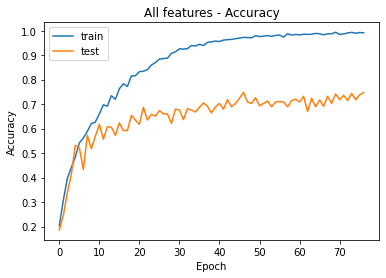

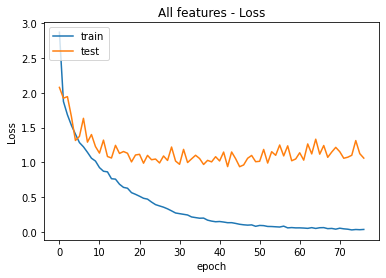

7/7 [==============================] - 0s 4ms/step - loss: 0.8711 - accuracy: 0.7511
Model Accuracy on unseen data: 75.11%
Model Loss on unseen data: 0.8710862994194031
INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/modelAllFeatures/assets


In [18]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('All features - Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('All features - Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

loss, acc = model.evaluate(X_testActual, y_test)
print("Model Accuracy on unseen data: {:5.2f}%".format(100*acc))
print("Model Loss on unseen data: {:}".format(loss))

model.save(basepath+"/modelAllFeatures")